In [121]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import Category10
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [122]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,45.6132,57.7381,35.4817,71.4413,75.5846,59.6099,93.7032,78.2685,75.4577
aaeB,48.4527,42.2968,41.1391,44.0555,47.6292,51.5953,56.3065,69.1718,58.5695
aaeR,49.0572,53.1486,33.4681,55.6848,43.8708,64.5169,51.3741,77.9266,79043.0000
aaeX,66.7322,64.9632,64.3814,81.0705,52586.0000,69.0053,64.9201,69.2443,56966.0000
aas,73.7846,77.6379,77.6300,65.1203,64.7268,77.6184,77.5343,95.9067,93.9019


In [60]:
datos = np.log2(datos+1)

In [123]:
q25 = np.quantile(datos, .25, interpolation="midpoint", axis=0)
q50 = np.quantile(datos, .5, interpolation="midpoint", axis=0)
q75 = np.quantile(datos, .75, interpolation="midpoint", axis=0)

upper = q75 + 1.5*(q75-q25)
lower = q25 - 1.5*(q75-q25)

In [124]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print("-----------------------------------------------")
print(hkg)

Quantidade de genes housekeeping: 21
-----------------------------------------------
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [125]:
X_train = datos.loc[hkg].dropna()
print("Número de genes de referência: ", X_train.shape[0])

Número de genes de referência:  21


In [126]:
d_cv = dict()
for idx, val in X_train.iterrows():
    d_cv[idx] = np.std(val)/np.mean(val)

In [127]:
cv_values = [i for i in d_cv.values()]
q25 = np.quantile(cv_values, q=.25)
q75 = np.quantile(cv_values, q=.75)
upper_hkg = q75 + 1.5*(q75 - q25)
lower_hkg = q25 - 1.5*(q75 - q25)

In [132]:
d_cv

{'cysG': 0.20837342552563382,
 'hcaT': 0.14737157573806184,
 'idnT': 1.865328694295125,
 'rrsA': 0.4778526292699359,
 'ihfB': 0.5148060436990624,
 'ssrA': 0.4740370626219607,
 'gyrA': 0.6581230861219886,
 'recA': 1.2628031334877596,
 'rpoB': 0.931997667813928,
 'rpoA': 2.6881300730100657,
 'gyrB': 0.4173455754507571,
 'rho': 1.0055990055074528,
 'ftsZ': 0.39703197705891247,
 'secA': 0.47395156749150685,
 'rpoC': 0.4746874482492953,
 'gmk': 0.2959083213810123,
 'adk': 0.36196857381231856,
 'rpoD': 0.5496293209603532,
 'dnaG': 0.4217087905225748,
 'glnA': 2.0318697876421683,
 'recF': 0.8990078798525019}

In [133]:
datos.loc["thrL"]

BB9     38.0937
BB10    40.1591
BB17    49.0678
BB19    48.0914
BB20    23.9811
BB21    71.6792
BB11    39.3704
BB12    75.8403
BB18    32.7585
Name: thrL, dtype: float64

In [ ]:
ftsZ, gap, gyrA, gyrB, recA, rho, rpoA, rpoB  secA

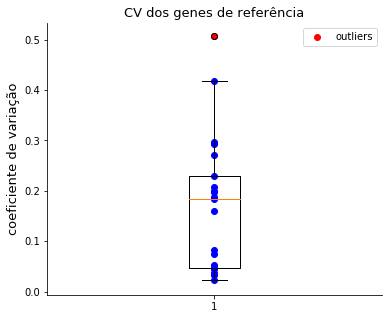

In [67]:
fig1 = plt.figure(figsize=(6,5))
i = 0
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("CV dos genes de referência", fontsize=13)
plt.ylabel("coeficiente de variação", fontsize=13)
for key in d_cv:
    if d_cv[key] <= upper_hkg and d_cv[key] >= lower_hkg:
        plt.scatter(1, d_cv[key], color="blue");
    else:
        plt.scatter(1, d_cv[key], color="red", label="outliers");
    i += 1
plt.boxplot(cv_values);
plt.legend();

In [68]:
print("max cv: ", upper_hkg)
print("------------ outliers -------------")
for key, val in d_cv.items():
    if val > upper_hkg or val < lower_hkg:
        print(key, val)
        
#X_train = X_train.drop("idnT")
X_train.shape

max cv:  0.5005366248219769
------------ outliers -------------
idnT 0.5082800362135752


(21, 9)

In [69]:
X_train = X_train.drop("idnT")

In [70]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [71]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [72]:
noise_input = 18
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  18


In [73]:
G.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                950       
_________________________________________________________________
dense_16 (Dense)             (None, 150)               7650      
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 1359      
_________________________________________________________________
reshape_3 (Reshape)          (None, 9)                 0         
Total params: 9,959
Trainable params: 9,959
Non-trainable params: 0
_________________________________________________________________


In [74]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (20, 18)
Dimension de los ejemplos generados: (20, 9)


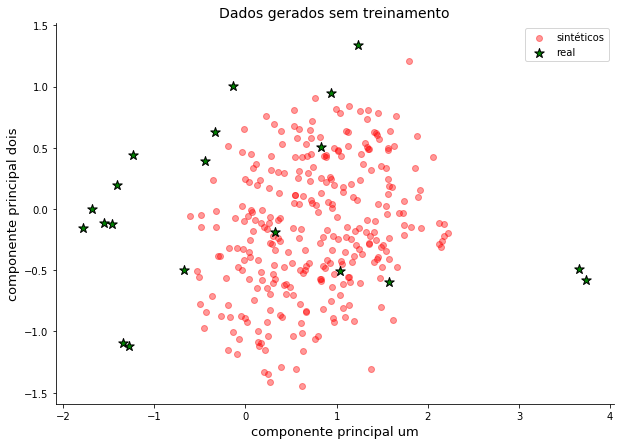

In [75]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
X_train_pca
noise = np.random.normal(loc=0, scale=1, size=(300, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_fake_pca = pca_real.transform(x_noise)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintéticos", alpha=.4)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [76]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [77]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

In [78]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [79]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [80]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=20, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (20, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((20,1)), np.zeros((20,1))))
        y_predict = D.predict_classes(X_test)
        f1_lag = f1_score(y_test, y_predict)
        fscore.append(np.mean((y_predict - y_test)**2))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, fscore

In [81]:
noise_input = 50
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.0001, momentum=0.92, decay=0.0001/2000)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [82]:
ep = 2000
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.815609],[Generator::loss: 0.851114], 1.107914[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.774451],[Generator::loss: 0.857844], 0.010596[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.754175],[Generator::loss: 0.861203], 0.010154[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.808721],[Generator::loss: 0.820240], 0.010014[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.806169],[Generator::loss: 0.876907], 0.010214[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.823942],[Generator::loss: 0.900142], 0.010362[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.783984],[Generator::loss: 0.854259], 0.010149[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.808676],[Generator::loss: 0.824224], 0.010398[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.768045],[Generator::loss: 0.815872], 0.010726[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.786333],[Generator::loss: 0.846211], 0.009995[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.813227],[Generator::loss: 0.780700], 

epoch:[100/2000] [Discriminator::d_loss: 0.673599],[Generator::loss: 0.731795], 0.015614[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.642175],[Generator::loss: 0.807348], 0.017117[sec]
epoch:[102/2000] [Discriminator::d_loss: 0.653453],[Generator::loss: 0.692691], 0.016581[sec]
epoch:[103/2000] [Discriminator::d_loss: 0.656080],[Generator::loss: 0.793398], 0.012759[sec]
epoch:[104/2000] [Discriminator::d_loss: 0.662429],[Generator::loss: 0.759959], 0.014735[sec]
epoch:[105/2000] [Discriminator::d_loss: 0.621867],[Generator::loss: 0.775005], 0.015994[sec]
epoch:[106/2000] [Discriminator::d_loss: 0.626403],[Generator::loss: 0.762912], 0.011741[sec]
epoch:[107/2000] [Discriminator::d_loss: 0.637935],[Generator::loss: 0.736984], 0.010161[sec]
epoch:[108/2000] [Discriminator::d_loss: 0.664906],[Generator::loss: 0.794145], 0.010415[sec]
epoch:[109/2000] [Discriminator::d_loss: 0.666011],[Generator::loss: 0.756928], 0.010271[sec]
epoch:[110/2000] [Discriminator::d_loss: 0.666046],[Generato

epoch:[204/2000] [Discriminator::d_loss: 0.630744],[Generator::loss: 0.806282], 0.018347[sec]
epoch:[205/2000] [Discriminator::d_loss: 0.604125],[Generator::loss: 0.771207], 0.016880[sec]
epoch:[206/2000] [Discriminator::d_loss: 0.612370],[Generator::loss: 0.733397], 0.010474[sec]
epoch:[207/2000] [Discriminator::d_loss: 0.643908],[Generator::loss: 0.770591], 0.010590[sec]
epoch:[208/2000] [Discriminator::d_loss: 0.622697],[Generator::loss: 0.760430], 0.010420[sec]
epoch:[209/2000] [Discriminator::d_loss: 0.606176],[Generator::loss: 0.755239], 0.011002[sec]
epoch:[210/2000] [Discriminator::d_loss: 0.651093],[Generator::loss: 0.753161], 0.010122[sec]
epoch:[211/2000] [Discriminator::d_loss: 0.630729],[Generator::loss: 0.799021], 0.010556[sec]
epoch:[212/2000] [Discriminator::d_loss: 0.589648],[Generator::loss: 0.750485], 0.010251[sec]
epoch:[213/2000] [Discriminator::d_loss: 0.618795],[Generator::loss: 0.771151], 0.010358[sec]
epoch:[214/2000] [Discriminator::d_loss: 0.634997],[Generato

epoch:[302/2000] [Discriminator::d_loss: 0.582020],[Generator::loss: 0.845612], 0.013626[sec]
epoch:[303/2000] [Discriminator::d_loss: 0.616282],[Generator::loss: 0.834852], 0.011135[sec]
epoch:[304/2000] [Discriminator::d_loss: 0.612441],[Generator::loss: 0.804247], 0.010343[sec]
epoch:[305/2000] [Discriminator::d_loss: 0.580835],[Generator::loss: 0.795153], 0.010186[sec]
epoch:[306/2000] [Discriminator::d_loss: 0.605450],[Generator::loss: 0.890701], 0.010073[sec]
epoch:[307/2000] [Discriminator::d_loss: 0.584081],[Generator::loss: 0.790274], 0.009979[sec]
epoch:[308/2000] [Discriminator::d_loss: 0.583586],[Generator::loss: 0.876982], 0.009990[sec]
epoch:[309/2000] [Discriminator::d_loss: 0.595946],[Generator::loss: 0.797578], 0.010284[sec]
epoch:[310/2000] [Discriminator::d_loss: 0.612447],[Generator::loss: 0.751231], 0.010209[sec]
epoch:[311/2000] [Discriminator::d_loss: 0.595437],[Generator::loss: 0.801214], 0.010598[sec]
epoch:[312/2000] [Discriminator::d_loss: 0.595788],[Generato

epoch:[402/2000] [Discriminator::d_loss: 0.563613],[Generator::loss: 0.905511], 0.011690[sec]
epoch:[403/2000] [Discriminator::d_loss: 0.597545],[Generator::loss: 0.840993], 0.011601[sec]
epoch:[404/2000] [Discriminator::d_loss: 0.575287],[Generator::loss: 0.853180], 0.010109[sec]
epoch:[405/2000] [Discriminator::d_loss: 0.569252],[Generator::loss: 0.857778], 0.010173[sec]
epoch:[406/2000] [Discriminator::d_loss: 0.559635],[Generator::loss: 0.827562], 0.010442[sec]
epoch:[407/2000] [Discriminator::d_loss: 0.570341],[Generator::loss: 0.857281], 0.009911[sec]
epoch:[408/2000] [Discriminator::d_loss: 0.567889],[Generator::loss: 0.785191], 0.010059[sec]
epoch:[409/2000] [Discriminator::d_loss: 0.635075],[Generator::loss: 0.821608], 0.010105[sec]
epoch:[410/2000] [Discriminator::d_loss: 0.577803],[Generator::loss: 0.821897], 0.010040[sec]
epoch:[411/2000] [Discriminator::d_loss: 0.610914],[Generator::loss: 0.844648], 0.010025[sec]
epoch:[412/2000] [Discriminator::d_loss: 0.572258],[Generato

epoch:[502/2000] [Discriminator::d_loss: 0.583095],[Generator::loss: 0.967173], 0.017006[sec]
epoch:[503/2000] [Discriminator::d_loss: 0.534603],[Generator::loss: 0.937570], 0.010229[sec]
epoch:[504/2000] [Discriminator::d_loss: 0.532358],[Generator::loss: 0.831666], 0.010260[sec]
epoch:[505/2000] [Discriminator::d_loss: 0.524287],[Generator::loss: 0.844610], 0.010097[sec]
epoch:[506/2000] [Discriminator::d_loss: 0.531970],[Generator::loss: 0.921499], 0.010196[sec]
epoch:[507/2000] [Discriminator::d_loss: 0.534474],[Generator::loss: 0.874536], 0.010210[sec]
epoch:[508/2000] [Discriminator::d_loss: 0.504031],[Generator::loss: 0.858123], 0.010154[sec]
epoch:[509/2000] [Discriminator::d_loss: 0.588607],[Generator::loss: 0.931928], 0.010125[sec]
epoch:[510/2000] [Discriminator::d_loss: 0.524317],[Generator::loss: 0.854019], 0.010201[sec]
epoch:[511/2000] [Discriminator::d_loss: 0.556875],[Generator::loss: 0.902555], 0.010221[sec]
epoch:[512/2000] [Discriminator::d_loss: 0.549807],[Generato

epoch:[601/2000] [Discriminator::d_loss: 0.544354],[Generator::loss: 0.902992], 0.010056[sec]
epoch:[602/2000] [Discriminator::d_loss: 0.527122],[Generator::loss: 0.958665], 0.015234[sec]
epoch:[603/2000] [Discriminator::d_loss: 0.527944],[Generator::loss: 0.857012], 0.010206[sec]
epoch:[604/2000] [Discriminator::d_loss: 0.539660],[Generator::loss: 0.866859], 0.010045[sec]
epoch:[605/2000] [Discriminator::d_loss: 0.539849],[Generator::loss: 0.810235], 0.009956[sec]
epoch:[606/2000] [Discriminator::d_loss: 0.535045],[Generator::loss: 0.841336], 0.009996[sec]
epoch:[607/2000] [Discriminator::d_loss: 0.528432],[Generator::loss: 0.913544], 0.010076[sec]
epoch:[608/2000] [Discriminator::d_loss: 0.550574],[Generator::loss: 0.810912], 0.010106[sec]
epoch:[609/2000] [Discriminator::d_loss: 0.505083],[Generator::loss: 0.761700], 0.010016[sec]
epoch:[610/2000] [Discriminator::d_loss: 0.568934],[Generator::loss: 0.860488], 0.010143[sec]
epoch:[611/2000] [Discriminator::d_loss: 0.530079],[Generato

epoch:[700/2000] [Discriminator::d_loss: 0.535111],[Generator::loss: 0.789256], 0.011843[sec]
epoch:[701/2000] [Discriminator::d_loss: 0.551417],[Generator::loss: 0.853441], 0.011453[sec]
epoch:[702/2000] [Discriminator::d_loss: 0.524391],[Generator::loss: 0.950878], 0.010404[sec]
epoch:[703/2000] [Discriminator::d_loss: 0.555964],[Generator::loss: 0.972275], 0.010456[sec]
epoch:[704/2000] [Discriminator::d_loss: 0.562659],[Generator::loss: 0.932126], 0.010183[sec]
epoch:[705/2000] [Discriminator::d_loss: 0.531063],[Generator::loss: 0.848663], 0.009982[sec]
epoch:[706/2000] [Discriminator::d_loss: 0.509242],[Generator::loss: 0.874060], 0.010440[sec]
epoch:[707/2000] [Discriminator::d_loss: 0.572276],[Generator::loss: 0.931979], 0.010415[sec]
epoch:[708/2000] [Discriminator::d_loss: 0.533758],[Generator::loss: 0.896596], 0.010212[sec]
epoch:[709/2000] [Discriminator::d_loss: 0.542911],[Generator::loss: 0.968906], 0.010160[sec]
epoch:[710/2000] [Discriminator::d_loss: 0.540517],[Generato

epoch:[800/2000] [Discriminator::d_loss: 0.590030],[Generator::loss: 0.822324], 0.010321[sec]
epoch:[801/2000] [Discriminator::d_loss: 0.511564],[Generator::loss: 0.920209], 0.016201[sec]
epoch:[802/2000] [Discriminator::d_loss: 0.588813],[Generator::loss: 0.865287], 0.010038[sec]
epoch:[803/2000] [Discriminator::d_loss: 0.567501],[Generator::loss: 0.805673], 0.011399[sec]
epoch:[804/2000] [Discriminator::d_loss: 0.515514],[Generator::loss: 0.876253], 0.011637[sec]
epoch:[805/2000] [Discriminator::d_loss: 0.531320],[Generator::loss: 0.906816], 0.010087[sec]
epoch:[806/2000] [Discriminator::d_loss: 0.641216],[Generator::loss: 1.024367], 0.010009[sec]
epoch:[807/2000] [Discriminator::d_loss: 0.535612],[Generator::loss: 0.979335], 0.010209[sec]
epoch:[808/2000] [Discriminator::d_loss: 0.537504],[Generator::loss: 0.906750], 0.010051[sec]
epoch:[809/2000] [Discriminator::d_loss: 0.568616],[Generator::loss: 0.785863], 0.010333[sec]
epoch:[810/2000] [Discriminator::d_loss: 0.514000],[Generato

epoch:[891/2000] [Discriminator::d_loss: 0.561096],[Generator::loss: 0.948390], 0.011379[sec]
epoch:[892/2000] [Discriminator::d_loss: 0.522564],[Generator::loss: 0.796270], 0.015570[sec]
epoch:[893/2000] [Discriminator::d_loss: 0.565091],[Generator::loss: 0.794853], 0.010370[sec]
epoch:[894/2000] [Discriminator::d_loss: 0.573421],[Generator::loss: 0.828118], 0.010373[sec]
epoch:[895/2000] [Discriminator::d_loss: 0.540570],[Generator::loss: 0.841232], 0.010211[sec]
epoch:[896/2000] [Discriminator::d_loss: 0.579141],[Generator::loss: 0.827575], 0.010205[sec]
epoch:[897/2000] [Discriminator::d_loss: 0.576166],[Generator::loss: 0.929056], 0.010304[sec]
epoch:[898/2000] [Discriminator::d_loss: 0.599514],[Generator::loss: 0.938978], 0.010548[sec]
epoch:[899/2000] [Discriminator::d_loss: 0.569677],[Generator::loss: 0.900449], 0.010391[sec]
epoch:[900/2000] [Discriminator::d_loss: 0.572980],[Generator::loss: 0.921985], 0.009999[sec]
epoch:[901/2000] [Discriminator::d_loss: 0.600980],[Generato

epoch:[984/2000] [Discriminator::d_loss: 0.649740],[Generator::loss: 0.791715], 0.016649[sec]
epoch:[985/2000] [Discriminator::d_loss: 0.651878],[Generator::loss: 0.937563], 0.010486[sec]
epoch:[986/2000] [Discriminator::d_loss: 0.587074],[Generator::loss: 0.912506], 0.010301[sec]
epoch:[987/2000] [Discriminator::d_loss: 0.617166],[Generator::loss: 0.850840], 0.010221[sec]
epoch:[988/2000] [Discriminator::d_loss: 0.663396],[Generator::loss: 0.985431], 0.010077[sec]
epoch:[989/2000] [Discriminator::d_loss: 0.631759],[Generator::loss: 0.957628], 0.010266[sec]
epoch:[990/2000] [Discriminator::d_loss: 0.630927],[Generator::loss: 1.002872], 0.010517[sec]
epoch:[991/2000] [Discriminator::d_loss: 0.646084],[Generator::loss: 0.840716], 0.010305[sec]
epoch:[992/2000] [Discriminator::d_loss: 0.644609],[Generator::loss: 0.910719], 0.010249[sec]
epoch:[993/2000] [Discriminator::d_loss: 0.597540],[Generator::loss: 0.664554], 0.009845[sec]
epoch:[994/2000] [Discriminator::d_loss: 0.591535],[Generato

epoch:[1081/2000] [Discriminator::d_loss: 0.673589],[Generator::loss: 0.797536], 0.012049[sec]
epoch:[1082/2000] [Discriminator::d_loss: 0.694075],[Generator::loss: 0.871086], 0.014833[sec]
epoch:[1083/2000] [Discriminator::d_loss: 0.685879],[Generator::loss: 0.886648], 0.012268[sec]
epoch:[1084/2000] [Discriminator::d_loss: 0.670713],[Generator::loss: 0.733119], 0.018678[sec]
epoch:[1085/2000] [Discriminator::d_loss: 0.691455],[Generator::loss: 0.905514], 0.016196[sec]
epoch:[1086/2000] [Discriminator::d_loss: 0.609321],[Generator::loss: 0.862492], 0.018071[sec]
epoch:[1087/2000] [Discriminator::d_loss: 0.642565],[Generator::loss: 0.829982], 0.018587[sec]
epoch:[1088/2000] [Discriminator::d_loss: 0.669460],[Generator::loss: 0.820337], 0.017127[sec]
epoch:[1089/2000] [Discriminator::d_loss: 0.580727],[Generator::loss: 0.864344], 0.019733[sec]
epoch:[1090/2000] [Discriminator::d_loss: 0.687678],[Generator::loss: 0.751720], 0.018485[sec]
epoch:[1091/2000] [Discriminator::d_loss: 0.706045

epoch:[1184/2000] [Discriminator::d_loss: 0.660921],[Generator::loss: 0.780712], 0.016366[sec]
epoch:[1185/2000] [Discriminator::d_loss: 0.639650],[Generator::loss: 0.842797], 0.010387[sec]
epoch:[1186/2000] [Discriminator::d_loss: 0.621446],[Generator::loss: 0.813023], 0.010520[sec]
epoch:[1187/2000] [Discriminator::d_loss: 0.643713],[Generator::loss: 0.831473], 0.010232[sec]
epoch:[1188/2000] [Discriminator::d_loss: 0.657052],[Generator::loss: 0.806379], 0.010177[sec]
epoch:[1189/2000] [Discriminator::d_loss: 0.634425],[Generator::loss: 0.819674], 0.010113[sec]
epoch:[1190/2000] [Discriminator::d_loss: 0.652831],[Generator::loss: 0.824965], 0.010266[sec]
epoch:[1191/2000] [Discriminator::d_loss: 0.663856],[Generator::loss: 0.861511], 0.010164[sec]
epoch:[1192/2000] [Discriminator::d_loss: 0.650838],[Generator::loss: 0.795714], 0.009916[sec]
epoch:[1193/2000] [Discriminator::d_loss: 0.685775],[Generator::loss: 0.837996], 0.009865[sec]
epoch:[1194/2000] [Discriminator::d_loss: 0.683106

epoch:[1283/2000] [Discriminator::d_loss: 0.727358],[Generator::loss: 0.876879], 0.016332[sec]
epoch:[1284/2000] [Discriminator::d_loss: 0.670625],[Generator::loss: 0.823542], 0.010395[sec]
epoch:[1285/2000] [Discriminator::d_loss: 0.670465],[Generator::loss: 0.904701], 0.010141[sec]
epoch:[1286/2000] [Discriminator::d_loss: 0.724535],[Generator::loss: 0.891625], 0.010301[sec]
epoch:[1287/2000] [Discriminator::d_loss: 0.680977],[Generator::loss: 0.672968], 0.010249[sec]
epoch:[1288/2000] [Discriminator::d_loss: 0.651753],[Generator::loss: 0.792366], 0.011122[sec]
epoch:[1289/2000] [Discriminator::d_loss: 0.684971],[Generator::loss: 0.756761], 0.010150[sec]
epoch:[1290/2000] [Discriminator::d_loss: 0.690076],[Generator::loss: 0.863537], 0.010559[sec]
epoch:[1291/2000] [Discriminator::d_loss: 0.663687],[Generator::loss: 0.760660], 0.010441[sec]
epoch:[1292/2000] [Discriminator::d_loss: 0.666195],[Generator::loss: 0.854071], 0.011595[sec]
epoch:[1293/2000] [Discriminator::d_loss: 0.675371

epoch:[1381/2000] [Discriminator::d_loss: 0.652399],[Generator::loss: 0.821314], 0.010373[sec]
epoch:[1382/2000] [Discriminator::d_loss: 0.690591],[Generator::loss: 0.820662], 0.015887[sec]
epoch:[1383/2000] [Discriminator::d_loss: 0.676876],[Generator::loss: 0.920125], 0.010571[sec]
epoch:[1384/2000] [Discriminator::d_loss: 0.706264],[Generator::loss: 0.773871], 0.010990[sec]
epoch:[1385/2000] [Discriminator::d_loss: 0.684161],[Generator::loss: 0.820395], 0.010278[sec]
epoch:[1386/2000] [Discriminator::d_loss: 0.687988],[Generator::loss: 0.683494], 0.010086[sec]
epoch:[1387/2000] [Discriminator::d_loss: 0.677766],[Generator::loss: 0.767499], 0.010048[sec]
epoch:[1388/2000] [Discriminator::d_loss: 0.646293],[Generator::loss: 0.793071], 0.010372[sec]
epoch:[1389/2000] [Discriminator::d_loss: 0.693851],[Generator::loss: 0.834328], 0.010135[sec]
epoch:[1390/2000] [Discriminator::d_loss: 0.718944],[Generator::loss: 0.810681], 0.010552[sec]
epoch:[1391/2000] [Discriminator::d_loss: 0.643372

epoch:[1475/2000] [Discriminator::d_loss: 0.639123],[Generator::loss: 0.700331], 0.010949[sec]
epoch:[1476/2000] [Discriminator::d_loss: 0.642703],[Generator::loss: 0.717031], 0.012501[sec]
epoch:[1477/2000] [Discriminator::d_loss: 0.673054],[Generator::loss: 0.697586], 0.010391[sec]
epoch:[1478/2000] [Discriminator::d_loss: 0.624355],[Generator::loss: 0.688770], 0.010430[sec]
epoch:[1479/2000] [Discriminator::d_loss: 0.713607],[Generator::loss: 0.700082], 0.010391[sec]
epoch:[1480/2000] [Discriminator::d_loss: 0.714989],[Generator::loss: 0.759568], 0.010249[sec]
epoch:[1481/2000] [Discriminator::d_loss: 0.686849],[Generator::loss: 0.746659], 0.010182[sec]
epoch:[1482/2000] [Discriminator::d_loss: 0.688734],[Generator::loss: 0.795259], 0.010137[sec]
epoch:[1483/2000] [Discriminator::d_loss: 0.664525],[Generator::loss: 0.796155], 0.010475[sec]
epoch:[1484/2000] [Discriminator::d_loss: 0.708493],[Generator::loss: 0.786849], 0.010406[sec]
epoch:[1485/2000] [Discriminator::d_loss: 0.693046

epoch:[1579/2000] [Discriminator::d_loss: 0.704513],[Generator::loss: 0.847333], 0.010735[sec]
epoch:[1580/2000] [Discriminator::d_loss: 0.711000],[Generator::loss: 0.806033], 0.012195[sec]
epoch:[1581/2000] [Discriminator::d_loss: 0.681953],[Generator::loss: 0.691257], 0.010680[sec]
epoch:[1582/2000] [Discriminator::d_loss: 0.742798],[Generator::loss: 0.725609], 0.010314[sec]
epoch:[1583/2000] [Discriminator::d_loss: 0.688389],[Generator::loss: 0.754981], 0.010159[sec]
epoch:[1584/2000] [Discriminator::d_loss: 0.679698],[Generator::loss: 0.769216], 0.010293[sec]
epoch:[1585/2000] [Discriminator::d_loss: 0.702467],[Generator::loss: 0.790719], 0.010299[sec]
epoch:[1586/2000] [Discriminator::d_loss: 0.706278],[Generator::loss: 0.735432], 0.009923[sec]
epoch:[1587/2000] [Discriminator::d_loss: 0.700644],[Generator::loss: 0.684432], 0.010231[sec]
epoch:[1588/2000] [Discriminator::d_loss: 0.760532],[Generator::loss: 0.735854], 0.010190[sec]
epoch:[1589/2000] [Discriminator::d_loss: 0.714308

epoch:[1676/2000] [Discriminator::d_loss: 0.703434],[Generator::loss: 0.786701], 0.014716[sec]
epoch:[1677/2000] [Discriminator::d_loss: 0.698129],[Generator::loss: 0.645362], 0.012194[sec]
epoch:[1678/2000] [Discriminator::d_loss: 0.713814],[Generator::loss: 0.763332], 0.010408[sec]
epoch:[1679/2000] [Discriminator::d_loss: 0.672786],[Generator::loss: 0.812700], 0.011470[sec]
epoch:[1680/2000] [Discriminator::d_loss: 0.723920],[Generator::loss: 0.732633], 0.010927[sec]
epoch:[1681/2000] [Discriminator::d_loss: 0.718893],[Generator::loss: 0.747632], 0.011158[sec]
epoch:[1682/2000] [Discriminator::d_loss: 0.668918],[Generator::loss: 0.687163], 0.010620[sec]
epoch:[1683/2000] [Discriminator::d_loss: 0.683279],[Generator::loss: 0.753290], 0.010877[sec]
epoch:[1684/2000] [Discriminator::d_loss: 0.688543],[Generator::loss: 0.737555], 0.011235[sec]
epoch:[1685/2000] [Discriminator::d_loss: 0.702593],[Generator::loss: 0.730761], 0.010514[sec]
epoch:[1686/2000] [Discriminator::d_loss: 0.659448

epoch:[1769/2000] [Discriminator::d_loss: 0.706783],[Generator::loss: 0.654678], 0.010980[sec]
epoch:[1770/2000] [Discriminator::d_loss: 0.714007],[Generator::loss: 0.752823], 0.014665[sec]
epoch:[1771/2000] [Discriminator::d_loss: 0.710348],[Generator::loss: 0.784286], 0.012483[sec]
epoch:[1772/2000] [Discriminator::d_loss: 0.722456],[Generator::loss: 0.666644], 0.013133[sec]
epoch:[1773/2000] [Discriminator::d_loss: 0.712744],[Generator::loss: 0.740759], 0.016465[sec]
epoch:[1774/2000] [Discriminator::d_loss: 0.672529],[Generator::loss: 0.745461], 0.015528[sec]
epoch:[1775/2000] [Discriminator::d_loss: 0.707828],[Generator::loss: 0.757654], 0.013972[sec]
epoch:[1776/2000] [Discriminator::d_loss: 0.716771],[Generator::loss: 0.736891], 0.014447[sec]
epoch:[1777/2000] [Discriminator::d_loss: 0.678799],[Generator::loss: 0.728073], 0.012251[sec]
epoch:[1778/2000] [Discriminator::d_loss: 0.672156],[Generator::loss: 0.739829], 0.010462[sec]
epoch:[1779/2000] [Discriminator::d_loss: 0.709191

epoch:[1868/2000] [Discriminator::d_loss: 0.721197],[Generator::loss: 0.648622], 0.011811[sec]
epoch:[1869/2000] [Discriminator::d_loss: 0.698323],[Generator::loss: 0.797343], 0.011890[sec]
epoch:[1870/2000] [Discriminator::d_loss: 0.710222],[Generator::loss: 0.668380], 0.010467[sec]
epoch:[1871/2000] [Discriminator::d_loss: 0.677568],[Generator::loss: 0.714725], 0.010553[sec]
epoch:[1872/2000] [Discriminator::d_loss: 0.690281],[Generator::loss: 0.666318], 0.010159[sec]
epoch:[1873/2000] [Discriminator::d_loss: 0.701091],[Generator::loss: 0.704054], 0.010296[sec]
epoch:[1874/2000] [Discriminator::d_loss: 0.688139],[Generator::loss: 0.735158], 0.009876[sec]
epoch:[1875/2000] [Discriminator::d_loss: 0.704808],[Generator::loss: 0.784225], 0.010515[sec]
epoch:[1876/2000] [Discriminator::d_loss: 0.692747],[Generator::loss: 0.778765], 0.010395[sec]
epoch:[1877/2000] [Discriminator::d_loss: 0.714492],[Generator::loss: 0.737367], 0.010682[sec]
epoch:[1878/2000] [Discriminator::d_loss: 0.704355

epoch:[1955/2000] [Discriminator::d_loss: 0.677360],[Generator::loss: 0.758788], 0.013805[sec]
epoch:[1956/2000] [Discriminator::d_loss: 0.696927],[Generator::loss: 0.686735], 0.011720[sec]
epoch:[1957/2000] [Discriminator::d_loss: 0.687236],[Generator::loss: 0.697542], 0.010442[sec]
epoch:[1958/2000] [Discriminator::d_loss: 0.700991],[Generator::loss: 0.778488], 0.010697[sec]
epoch:[1959/2000] [Discriminator::d_loss: 0.683921],[Generator::loss: 0.702985], 0.010108[sec]
epoch:[1960/2000] [Discriminator::d_loss: 0.694724],[Generator::loss: 0.683813], 0.010154[sec]
epoch:[1961/2000] [Discriminator::d_loss: 0.692306],[Generator::loss: 0.745051], 0.010228[sec]
epoch:[1962/2000] [Discriminator::d_loss: 0.672350],[Generator::loss: 0.707107], 0.010259[sec]
epoch:[1963/2000] [Discriminator::d_loss: 0.676328],[Generator::loss: 0.713253], 0.010050[sec]
epoch:[1964/2000] [Discriminator::d_loss: 0.691575],[Generator::loss: 0.741138], 0.009841[sec]
epoch:[1965/2000] [Discriminator::d_loss: 0.668820

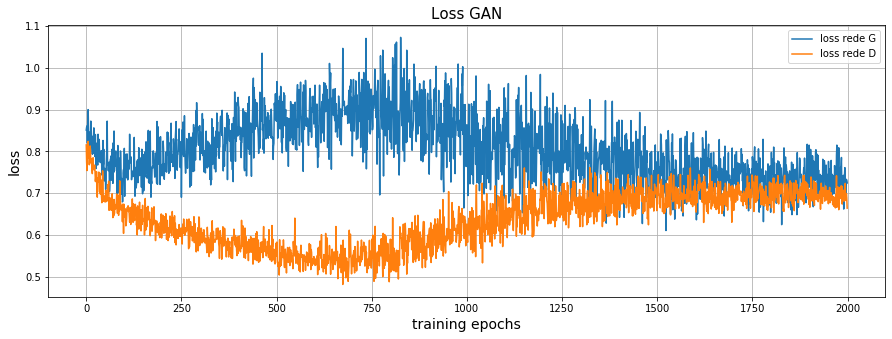

In [83]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

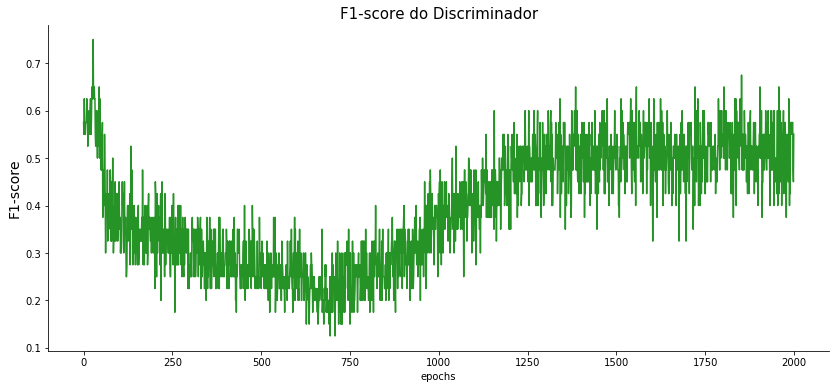

In [84]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(20, 2) (300, 2)


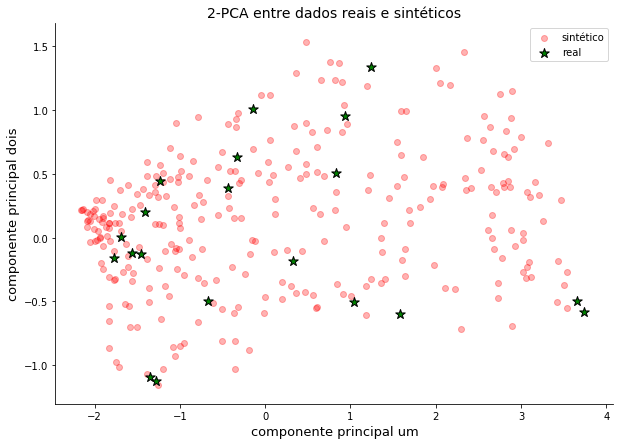

In [85]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [89]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(np.mean((y_test - y_predict)**2))

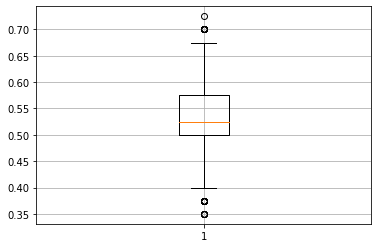

In [90]:
plt.grid("y")
plt.boxplot(score);

In [91]:
X_nov = np.concatenate((X_train, X_sint))

In [98]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel="poly", degree=1, gamma='scale').fit(X_train)

np.mean(clf.predict(X_nov) == 1)

0.525

In [99]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4293, 9)

In [100]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [101]:
datos = datos.drop(hkg)
datos.shape

(4272, 9)

In [ ]:
cand_cv = dict()
for idx, val in datos.iterrows():
    cand_cv[idx] = np.std(val)/np.mean(val)

In [89]:
predict_cand = clf.predict(datos)

In [92]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]

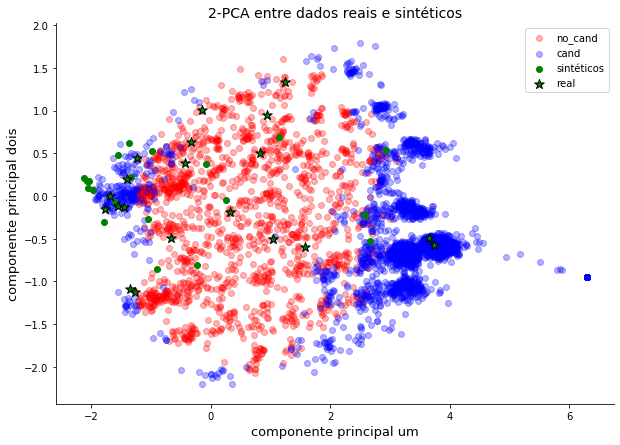

In [95]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();